# Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import random

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [2]:
TRAIN_DATASET_PATH = './data/project_task/train.csv'
TEST_DATASET_PATH = './data/project_task/test.csv'

Считываем наборы данных

In [3]:
data_train = pd.read_csv(TRAIN_DATASET_PATH)
data_test = pd.read_csv(TEST_DATASET_PATH)

Преобразуем **Id** к строковому типу

In [4]:
data_train['Id'] = data_train['Id'].astype(str)
data_test['Id'] = data_test['Id'].astype(str)
data_train['DistrictId'] = data_train['DistrictId'].astype(str)
data_test['DistrictId'] = data_test['DistrictId'].astype(str)

Посмотрим распределение целевой переменной **Price**

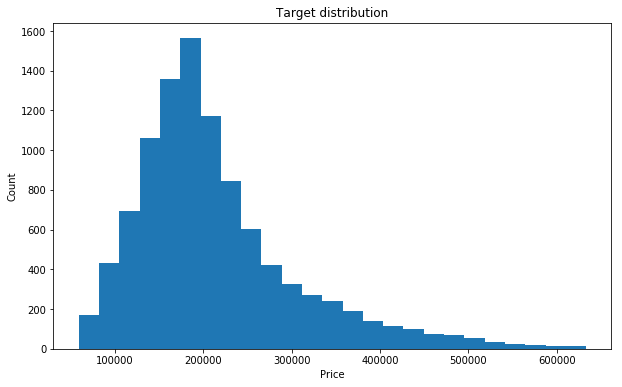

In [5]:
plt.figure(figsize=(10, 6))

plt.hist(data_train['Price'], bins=25)

plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [6]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


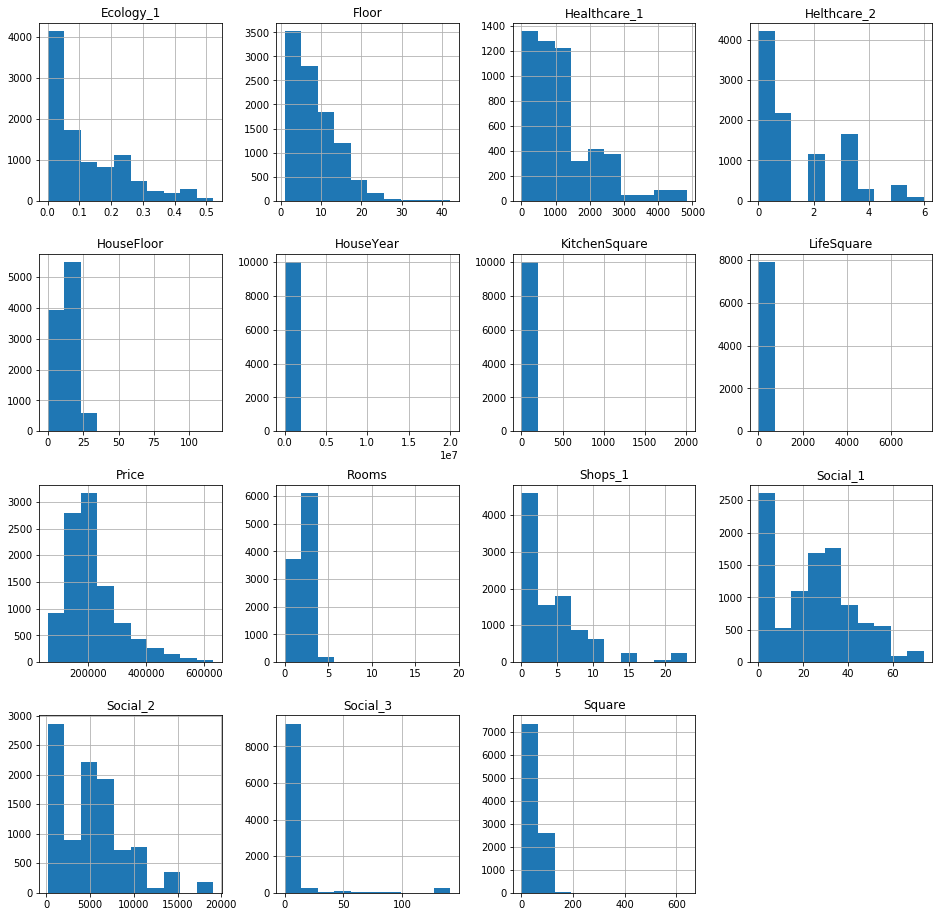

In [7]:
data_train[list(data_train.select_dtypes(exclude='object').columns)].hist(
    figsize=(16,16)
)
plt.show()

* Отсутствуют значения в **LifeSquare**, **Healthcare_1**.
* Аномально высокие значения в **Rooms**, **LifeSquare**, **KitchenSquare**. 
* Минимальное значение в **Square** меньше, чем минимальное в **LifeSquare** или в **KitchenSquare**.
* **Rooms**, **KitchenSquare**, **HouseFloor** имеют нулевые значения.

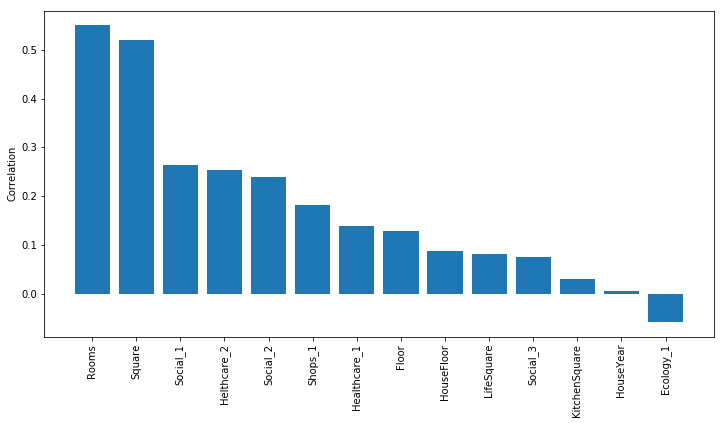

In [8]:
correlation = data_train.corrwith(data_train['Price']).sort_values(ascending=False).drop('Price')
plt.figure(figsize=(12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.ylabel('Correlation')
plt.show()

### **KitchenSquare**

In [9]:
data_train['KitchenSquare'].sort_values().tail(10)

5273      73.0
3956      75.0
2831      78.0
2785      84.0
2454      96.0
7733     112.0
5002     112.0
286      123.0
6505    1970.0
9520    2014.0
Name: KitchenSquare, dtype: float64

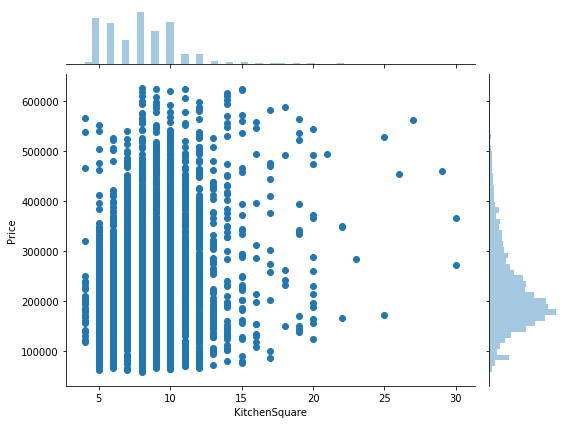

In [10]:
data_temp = data_train.loc[(data_train['KitchenSquare'] < 31) & (data_train['KitchenSquare'] > 3)]
jointplt = sns.jointplot(data_temp['KitchenSquare'], data_temp['Price'])
jointplt.fig.set_figwidth(8)
jointplt.fig.set_figheight(6)

**Rooms**

In [11]:
data_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

**Rooms** определим от 1 до 5.

**HouseFloor**

In [12]:
data_train['HouseFloor'][data_train['HouseFloor'] == 0].count()

269

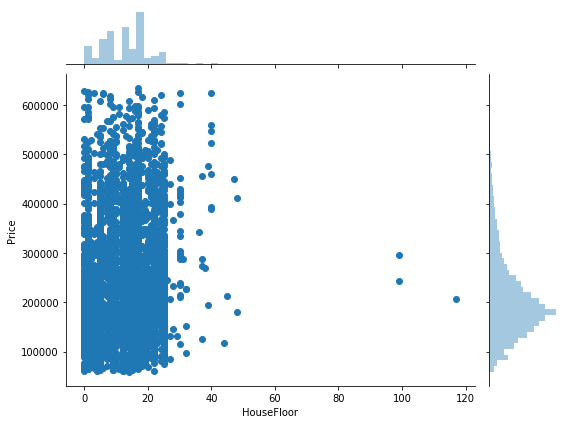

In [13]:
jointplt = sns.jointplot(data_train['HouseFloor'], data_train['Price'])
jointplt.fig.set_figwidth(8)
jointplt.fig.set_figheight(6)

**HouseFloor** определим от 1 до 50

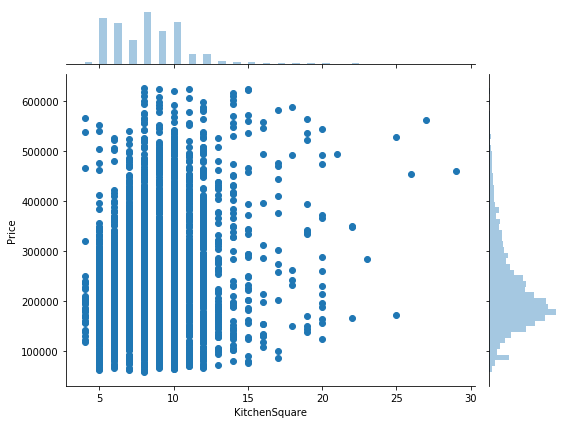

In [14]:
data_temp = data_train[(data_train['KitchenSquare'] < 30) & (data_train['KitchenSquare'] > 3)]
jointplt = sns.jointplot(data_temp['KitchenSquare'], data_temp['Price'])
jointplt.fig.set_figwidth(8)
jointplt.fig.set_figheight(6)

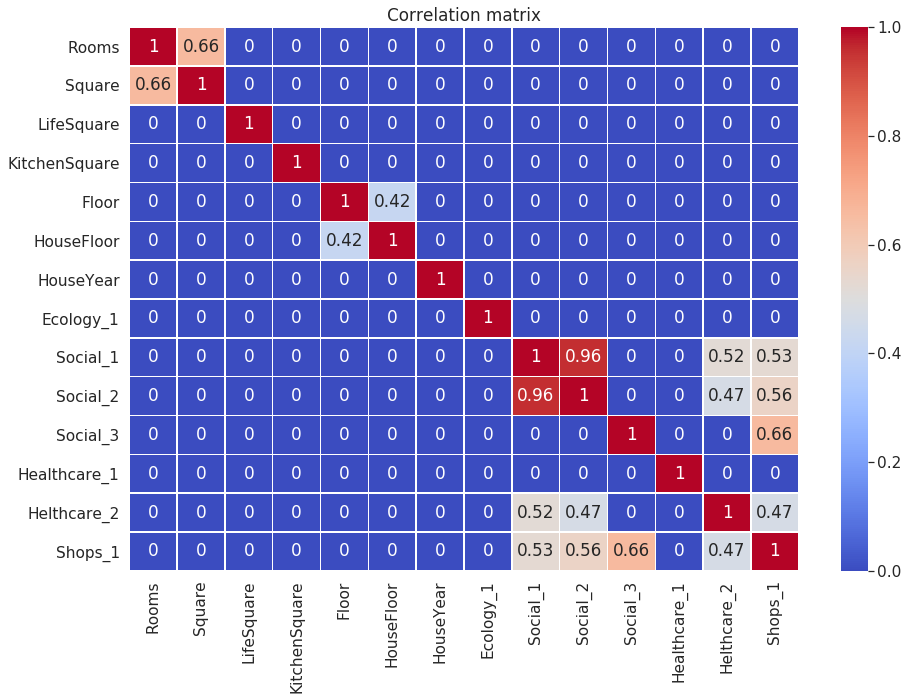

In [15]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = data_train.drop('Price', axis=1).corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [16]:
class DataPreparation:
    def __init__(self):
        """Константы и средние значения"""
        self.square_min =  10
        self.square_max = 250  # 300
        
        self.l_square_min = 9
        self.l_square_max = 150  # 200
        
        self.k_square_min = 3
        self.k_square_max = 30
        
        self.h_floor_min = 1
        self.h_floor_max = 6
        
        self.room_min = 1
        self.room_max = 5
        
        self.current_year = dt.datetime.now().year
        
        self.med_healthcare_1 = None
        self.med_l_square = None
        
        self.med_price_by_district = None
        
    def meds_and_new_features(self, df):
        self.med_l_square = df['LifeSquare'].median()
        self.med_healthcare_1 = df['Healthcare_1'].median()
        self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
        
    def prepare(self, df):
        # Обработка пропусков
        df['LifeSquare'] = df['LifeSquare'].fillna(self.med_l_square)
        df['Healthcare_1'] = df['Healthcare_1'].fillna(self.med_healthcare_1)

        df.loc[(df['Square'] > self.square_max), 'Square'] = self.square_max
        df.loc[(df['Square'] < self.square_min), 'Square'] = self.square_min
        
        df.loc[(df['LifeSquare'] < self.l_square_min), 'LifeSquare'] = self.l_square_min
        df.loc[(df['LifeSquare'] > self.l_square_max), 'LifeSquare'] = self.l_square_max

        df.loc[(df['KitchenSquare'] < self.k_square_min), 'KitchenSquare'] = self.k_square_min
        df.loc[(df['KitchenSquare'] > self.k_square_max), 'KitchenSquare'] = self.k_square_max

        df.loc[(df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year

        df.loc[(df['Rooms'] > self.room_max), 'Rooms'] = self.room_max
        df.loc[(df['Rooms'] < self.room_min), 'Rooms'] = self.room_min

        df.loc[(df['HouseFloor'] < self.h_floor_min), 'HouseFloor'] = self.h_floor_min
        df.loc[(df['HouseFloor'] > self.h_floor_max), 'HouseFloor'] = self.h_floor_max

        # если HouseFloor < Floor, то заменяем Floor на randint(1, x)
        floor_outliers = df[df['Floor'] > df['HouseFloor']].index

        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(
            lambda x: random.randint(1, x)
        )
        # Преобразуем категориальные признаки
        df['Ecology_2'] = df['Ecology_2'].replace({'A':0, 'B':1})
        df['Ecology_3'] = df['Ecology_3'].replace({'A':0, 'B':1})
        df['Shops_2'] = df['Shops_2'].replace({'A':0, 'B':1})
        
        # Добавляем новые признаки
        df = df.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        df['MedPriceByDistrict'].fillna(df['MedPriceByDistrict'].median(), inplace=True)

        
        return df


### Подготовка данных

In [17]:
data_prepare = DataPreparation()

# train
data_prepare.meds_and_new_features(data_train)
data_train = data_prepare.prepare(data_train)

# test
data_test = data_prepare.prepare(data_test)

In [18]:
data_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.907600,0.809687,1.000000,1.000000,2.000000,2.000000,5.000000
Square,5000.0,56.460103,19.065028,10.000000,41.906231,52.921340,66.285129,223.453689
LifeSquare,5000.0,35.543978,15.280618,9.000000,25.850152,32.781260,41.769526,150.000000
KitchenSquare,5000.0,6.460600,3.288071,3.000000,3.000000,6.000000,9.000000,30.000000
Floor,5000.0,3.464800,1.687759,1.000000,2.000000,4.000000,5.000000,6.000000
HouseFloor,5000.0,5.443600,1.363668,1.000000,6.000000,6.000000,6.000000,6.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Ecology_2,5000.0,0.990400,0.097518,0.000000,1.000000,1.000000,1.000000,1.000000
Ecology_3,5000.0,0.970200,0.170052,0.000000,1.000000,1.000000,1.000000,1.000000


#### Список параметров

In [19]:
features = ['MedPriceByDistrict', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2']
target = ['Price']

In [20]:
data_train = data_train[features + target]
data_test = data_test[features + ['Id']]
X = data_train[features]
y = data_train[target]


In [21]:
final_model = GradientBoostingRegressor(criterion='friedman_mse',
                                     max_depth=7,
                                     min_samples_leaf=50,  
                                     n_estimators=1000, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.02)
    
final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

In [22]:
print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.768


In [23]:
predictions_df = pd.DataFrame()
predictions_df['Id'] = data_test['Id'].copy()

data_test.set_index('Id', inplace=True)
data_test = data_test[features]

In [24]:
y_pred_final = final_model.predict(data_test)

predictions_df['Price'] = y_pred_final
predictions_df.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')

In [25]:
predictions_df.shape

(5000, 2)

From Kaggle:

    Name: predictions.csv

    Score: 0.72623

